<a href="https://colab.research.google.com/github/dunliangyang2010/Deep-Learning-practice/blob/master/keras_unet_multiclass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from glob import glob
from tqdm.auto import tqdm

In [ ]:
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import plot_model

In [ ]:
IMAGE_LIB = 'img/*.jpg'
MASK_LIB = 'mask/*.png'
IMG_SIZE = 256
SEED = 5566
NUM_CLASSES = 3

# Data

In [ ]:
img_paths = sorted(glob(IMAGE_LIB))
mask_paths = sorted(glob(MASK_LIB))

x_data = np.empty((len(img_paths), IMG_SIZE, IMG_SIZE, 3))
y_data = np.empty((len(img_paths), IMG_SIZE, IMG_SIZE, NUM_CLASSES))

for i, path in enumerate(tqdm(img_paths)):
    # read input image
    img = cv2.imread(path)[:, :, ::-1] # [:,:,0] # get channel 0 if it's a gray scale image
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.
    x_data[i] = img
    filename_img = os.path.split(path)[1] # filename_img: seg1.png
    filename = filename_img.split('.')[0] # filename: seg1
    # read mask image
    for j in range(NUM_CLASSES):
        mask = cv2.imread(os.path.join('./mask', f'{filename}_mask_{j}.png'))[:,:,0] # seg1_mask_0.png, seg1_mask_1.png, seg1_mask_2.png
        mask = mask / 255.
        mask[mask>=0.5] = 1.
        mask[mask<0.5] = 0
        mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))
        y_data[i, :, :, j] = mask


  0%|          | 0/1 [00:00<?, ?it/s]

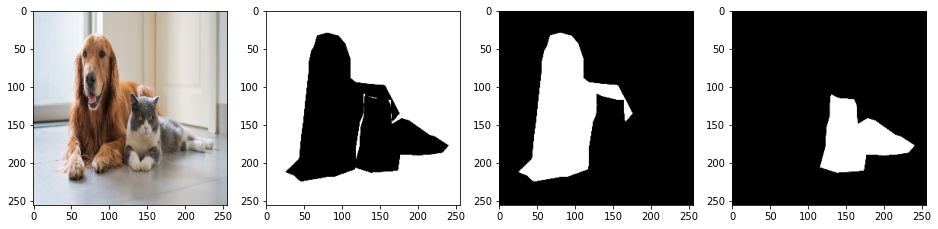

In [ ]:
fig, ax = plt.subplots(1,4, figsize = (16,4))
ax[0].imshow(x_data[0], cmap='gray')
ax[1].imshow(y_data[0, :, :, 0], cmap='gray')
ax[2].imshow(y_data[0, :, :, 1], cmap='gray')
ax[3].imshow(y_data[0, :, :, 2], cmap='gray')
plt.show()

In [ ]:
x_data.shape, y_data.shape

((1, 256, 256, 3), (1, 256, 256, 3))

In [ ]:
# x_data = np.expand_dims(x_data, axis=-1)
# x_data.shape, y_data.shape

# Model

In [ ]:
# Unet with Conv2DTranspose
input_layer = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
l = Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(input_layer)
c1 = Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c1)
l = Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(l)
c2 = Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c2)
l = Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(l)
c3 = Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(l)
l = MaxPool2D(strides=(2,2))(c3)
l = Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(l)
c4 = Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(l)
l = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c4), 
                 c3], axis=-1)
l = Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(l)
l = Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(l)
l = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(l), 
                 c2], axis=-1)
l = Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(l)
l = Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(l)
l = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(l), 
                 c1], axis=-1)
l = Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(l)
l = Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same')(l)

# filter數量要跟class一致, 包含標註的class數目+background
# 此為多元分類,activation改用softmax, 若二元才可考慮用sigmoid
output_layer = Conv2D(filters=NUM_CLASSES, kernel_size=(1,1), activation='softmax')(l)
                                                         
model = Model(input_layer, output_layer)

In [ ]:
model.compile(optimizer=Adam(), 
      loss=keras.losses.categorical_crossentropy)
# 多元分類,loss改用categorical_crossentropy

In [ ]:
hist = model.fit(x_data, y_data, batch_size=1,
                 epochs=100, verbose=2)

Epoch 1/100
1/1 - 0s - loss: 0.2650 - 74ms/epoch - 74ms/step
Epoch 2/100
1/1 - 0s - loss: 0.2520 - 71ms/epoch - 71ms/step
Epoch 3/100
1/1 - 0s - loss: 0.2487 - 69ms/epoch - 69ms/step
Epoch 4/100
1/1 - 0s - loss: 0.2539 - 66ms/epoch - 66ms/step
Epoch 5/100
1/1 - 0s - loss: 0.2450 - 65ms/epoch - 65ms/step
Epoch 6/100
1/1 - 0s - loss: 0.2338 - 63ms/epoch - 63ms/step
Epoch 7/100
1/1 - 0s - loss: 0.2364 - 59ms/epoch - 59ms/step
Epoch 8/100
1/1 - 0s - loss: 0.2330 - 61ms/epoch - 61ms/step
Epoch 9/100
1/1 - 0s - loss: 0.2205 - 58ms/epoch - 58ms/step
Epoch 10/100
1/1 - 0s - loss: 0.2182 - 54ms/epoch - 54ms/step
Epoch 11/100
1/1 - 0s - loss: 0.2127 - 53ms/epoch - 53ms/step
Epoch 12/100
1/1 - 0s - loss: 0.1984 - 52ms/epoch - 52ms/step
Epoch 13/100
1/1 - 0s - loss: 0.1979 - 53ms/epoch - 53ms/step
Epoch 14/100
1/1 - 0s - loss: 0.1867 - 52ms/epoch - 52ms/step
Epoch 15/100
1/1 - 0s - loss: 0.1785 - 51ms/epoch - 51ms/step
Epoch 16/100
1/1 - 0s - loss: 0.1703 - 50ms/epoch - 50ms/step
Epoch 17/100
1/1 

In [ ]:
model.save('multi-class-seg.h5')

## Display

In [ ]:
model = load_model('multi-class-seg.h5')

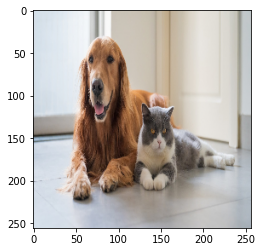

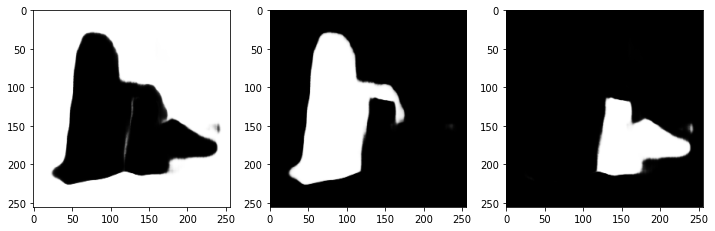

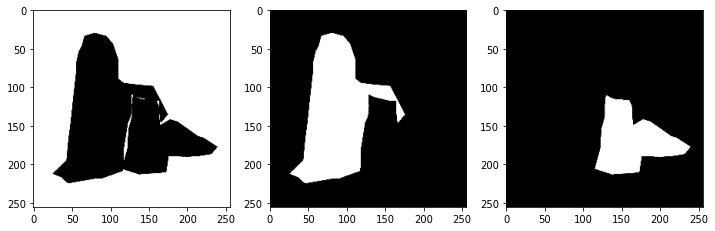

In [ ]:
img_input = x_data[0:1]
y_pred = model.predict(img_input)

# input img
plt.imshow(img_input[0, :, :, :])
plt.show()

# pred
fig, ax = plt.subplots(1,3,figsize=(12,4))
for i in range(NUM_CLASSES):
    pred_mask = y_pred[0, :, :, i]
    ax[i].imshow(pred_mask, cmap='gray')  
plt.show()

# Truth
fig, ax = plt.subplots(1,3,figsize=(12,4))
for i in range(NUM_CLASSES):
    y_truth = y_data[0, :, :, i]
    ax[i].imshow(y_truth, cmap='gray')  
plt.show()

#### Draw Color Mask

In [ ]:
all_mask = np.argmax(y_pred[0], axis=-1)
print(all_mask.shape)

(256, 256)


In [ ]:
# Class pixel count
np.unique(all_mask, return_counts=True)

(array([0, 1, 2]), array([44270, 14318,  6948]))

In [ ]:
# generate random color map
colors = np.random.randint(0, 256, size=(3, 3))
colors[0] = [0, 0, 0]
colors

array([[  0,   0,   0],
       [ 90, 221, 133],
       [ 54,  55, 209]])

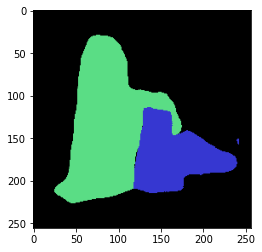

In [ ]:
# Mapping pixel class to color
mask_pred_show = np.array([colors[pixel] for pixel in all_mask])
plt.imshow(mask_pred_show)